In [10]:
from dataclasses import dataclass
from scipy.optimize import least_squares
from scipy.stats import nbinom
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [302]:
df = pd.read_table("histogram.tsv", names=("depth", "count")).query("30 <= depth <= 2000").copy()

In [303]:
df

,depth,count
24,30,754994
25,31,683363
26,32,621375
27,33,569062
28,34,522978
...,...,...
1990,1996,5374
1991,1997,5396
1992,1998,5363
1993,1999,5391


In [312]:
@dataclass
class KmerProfileModel:
    depths: np.ndarray
    counts: np.ndarray
    peaks: int = 4


    def get_error_counts(self, r, fraction):
        mu = 1
        p = r / (r + mu)
        total_count = self.counts.sum()
        log_likelihood = nbinom.logpmf(self.depths, r, p)
        if np.isnan(log_likelihood).sum() > 0:
            raise ValueError()
        error_counts = np.exp(np.log(total_count * fraction) + log_likelihood)
        if np.isnan(error_counts).sum() > 0:
            raise ValueError()
        return error_counts

    def get_peak_counts(self, r, p, fraction):
        total_count = self.counts.sum()
        log_likelihood = nbinom.logpmf(self.depths, r, p)
        return np.exp(np.log(total_count * fraction) + log_likelihood)

    def get_model_counts(self, error_dispersion, error_fraction, base_depth, bias, peak_fractions):
        total_count = self.counts.sum()
        model_counts = np.zeros(self.counts.shape)
        model_counts += self.get_error_counts(error_dispersion, error_fraction)

        for i in range(self.peaks):
            r = (i + 1) * base_depth / bias
            mu = (i + 1) * base_depth
            p = r / (r + mu)
            fraction = peak_fractions[i]
            model_counts += self.get_peak_counts(r, p, fraction)
        return model_counts

    def get_residual_sum_of_squares(self, error_dispersion, error_fraction, base_depth, bias, fractions):
        model_counts = self.get_model_counts(error_dispersion, error_fraction, base_depth, bias, fractions)
        return ((self.counts - model_counts) ** 2).sum()

    def get_cost(self, params, *args, **kw):
        error_dispersion = params[0]
        error_fraction = params[1]
        base_depth = params[2]
        bias = params[3]
        fractions = params[4:]
        return self.get_residual_sum_of_squares(error_dispersion, error_fraction, base_depth, bias, fractions)

    def optimize(self, estimated_base_depth, *args, **kw):
        initial_error_dispersion = 0.15
        initial_error_fraction = 8
        initial_bias = 0.5
        initial_fractions = np.ones(self.peaks) / (self.peaks + 0.01)
        initial_params = [
            initial_error_dispersion,
            initial_error_fraction,
            estimated_base_depth,
            initial_bias,
            *initial_fractions,
        ]
        lower_bounds = [1e-10, 1e-3, min(self.depths), 0.001] + [1e-10] * self.peaks
        upper_bounds = [1, 100, 1000, 1000] + [1 - 1e-10] * self.peaks
        bounds = (lower_bounds, upper_bounds)
        return least_squares(self.get_cost, initial_params, bounds=bounds, *args, **kw)


In [324]:
model = KmerProfileModel(df['depth'], df['count'], 12)

In [325]:
result = model.optimize(107)
result

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 1.196e+13]
           x: [ 1.506e-01  7.960e+00 ...  1.471e-03  2.575e-03]
        cost: 7.146410176220573e+25
         jac: [[ 1.664e+10  4.498e+10 ...  1.496e+12 -1.416e+09]]
        grad: [ 1.990e+23  5.377e+23 ...  1.788e+25 -1.693e+22]
  optimality: 4.2799395782968315e+24
 active_mask: [0 0 ... 0 0]
        nfev: 1231
        njev: 956

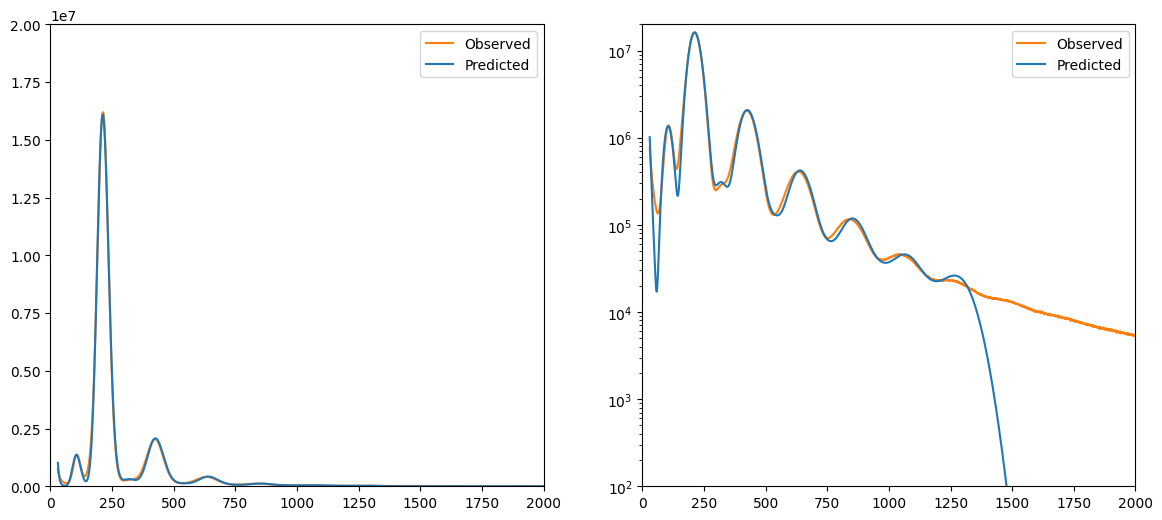

In [326]:
fitted_params = result.x
error_dispersion = fitted_params[0]
error_fraction = fitted_params[1]
base_depth = fitted_params[2]
bias = fitted_params[3]
peak_fractions = fitted_params[4:]
model_counts = model.get_model_counts(error_dispersion, error_fraction, base_depth, bias, peak_fractions)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for ax in (ax1, ax2):
    ax.plot(df['depth'], df['count'], color='tab:orange', label='Observed')
    ax.plot(df['depth'], model_counts, color='tab:blue', label='Predicted')
    ax.set_xlim(0, max(df['depth']))
    ax.legend(loc="upper right")

ax1.set_ylim(0, 0.2e8)
ax2.set_ylim(100, 0.2e8)
ax2.set_yscale('log')



In [39]:
model.get_peak_counts(200, 0.9, 1)

array([124128.26629807, 365291.7551057 , 945192.41633604, ...,
            0.        ,      0.        ,      0.        ])

In [25]:
nbinom.pmf([10, 100, 200], 100, 0.5)

array([3.28442046e-20, 2.81742395e-02, 6.80441503e-10])

In [26]:
nbinom.logpmf([10, 100, 200], 100, 0.5)

array([-44.86251164,  -3.56934721, -21.10827926])

In [27]:
np.exp(-44.86251164)

3.2844204718223304e-20

In [ ]:
def get_log_likelihood()